# Probabilistic Numerical Methods

Probabilistic numerical methods solve numerical problems from linear algebra, optimization, quadrature and differential equations using _probabilistic inference_. This approach captures uncertainty arising from finite computational resources and from stochastic input.

Even though PN methods return random variables which in their distribution represent this aforementioned uncertainty, they do not necessarily make use of random numbers. In order to illustrate what PN methods are and how they work consider the following deliberately simple numerical problem.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../probnum.mplstyle")

## A Simple Numerical Problem

Consider the following one-dimensional optimization problem $$\underset{x \in \mathbb{R}}{\operatorname{min}} f(x) = \underset{x \in \mathbb{R}}{\operatorname{min}} \frac{1}{2} ax^2 + bx + c,$$ where $f$ is a quadratic function and we assume $a > 0$. Since $f$ is a strictly convex function there exists a unique minimum given by $$f'(x_*) = 0 \iff x_*=-\frac{b}{a}.$$

In [2]:
import numpy as np
import probnum as pn

# Random number generator -- fix a seed.
rng = np.random.default_rng(seed=1)

# Quadratic objective function
a = 2
b = -1.0
c = 3.0
x_opt = -b / a


def f(x):
    return 0.5 * a * x ** 2 + b * x + c

Now suppose we are not given access to the coefficients, but only the ability to evaluate $f$ at arbitrary points. We can then evaluate the objective three times and solve the resulting $3 \times 3$ linear system to find the parameters $a$, $b$ and $c$.

## Introducing Noise

However, what happens if we go one step further and assume the parameters $(a,b,c)$ and therefore function evaluations are corrupted by noise? This is often the case in practice where $f$ might describe a complex physical system or depend on data. Can we still design a computationally efficient algorithm which finds the minimum?

Suppose we only have access to noisy evaluations $$\hat{y} = \hat{f}(x) = \frac{1}{2}(a + \varepsilon_a)x^2 + (b+\varepsilon_b)x + (c + \varepsilon_c)$$  of the objective function $f$ at $x$, where $\varepsilon = (\varepsilon_a, \varepsilon_b, \varepsilon_c) \sim \mathcal{N}(0, \Lambda)$ and $\Lambda \in \mathbb{R}^{3 \times 3}$ symmetric positive definite.

> *Remark*: The $n$-dimensional analogue of this case arises for example in supervised (deep) learning. In large-scale empirical risk minimization the available training data often does not fit into memory. Therefore during training only batches of data are considered which induces noise on the objective function and its gradient. Here $\hat{f}$ is analogous to the empirical risk on a given batch.

In [3]:
from probnum import randvars

# Noisy objective function
Lambda = np.diag([0.1, 0.05, 0.01])
eps = randvars.Normal(np.zeros(3), Lambda)


def f_hat(x, rng, noise=None):
    if noise is None:
        noise = eps.sample(rng=rng)
    return 0.5 * (a + noise[0]) * x ** 2 + (b + noise[1]) * x + c + noise[2]

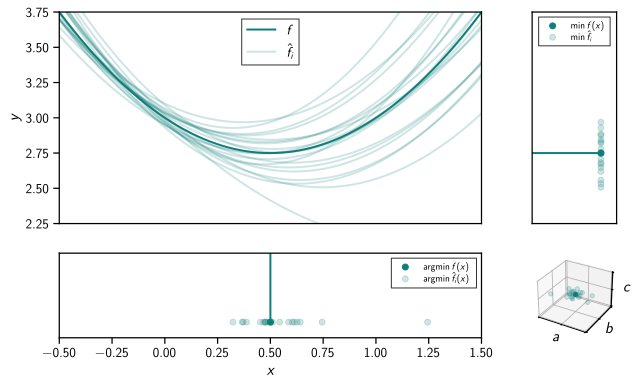

In [4]:
"""Plot objective and noisy function evaluations."""
from mpl_toolkits.mplot3d import Axes3D

# Plot setup
n_samples = 20
xx = np.linspace(x_opt - 1, x_opt + 1, 1000)

fig = plt.figure(figsize=[10, 6])
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 1], height_ratios=[2.5, 1])

ax00 = fig.add_subplot(gs[0, 0])
ax10 = fig.add_subplot(gs[1, 0], sharex=ax00)
ax01 = fig.add_subplot(gs[0, 1], sharey=ax00)
ax11 = fig.add_subplot(gs[1, 1], projection="3d")
ylim00 = [2.25, 3.75]
ylim10 = [-0.25, 1.1]

# Function
ax00.plot(xx, f(xx), label="$f$", color="C0")

# Parameters
ax11.scatter(a, b, c, color='C0', label="$(a, b, c)$")

# Function range
ax01.scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
ax01.hlines(y=f(x_opt), xmin=ylim10[0], xmax=ylim10[1] + ylim10[0], zorder=-1, color="C0")

# Domain
ax10.scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
ax10.vlines(x_opt, ymin=0, ymax=ylim10[1], zorder=-1, color="C0")

# Samples
for i in range(n_samples):
    noise = eps.sample(rng=rng)
    x_opt_noise = -(b + noise[1]) / (a + noise[0])
    if i == 0:
        sample_label = "$\\hat{f}_i$"
        sample_min_label = "$\min \\hat{f}_i$"
        sample_argmin_label = "$\operatorname{argmin} \hat{f}_i(x)$"
    else:
        sample_label = None
        sample_argmin_label = None
        sample_min_label = None
    ax00.plot(xx, f_hat(xx, rng, noise), color="C0", alpha=0.2, label=sample_label)
    ax10.scatter(x_opt_noise, 0, color="C0", alpha=0.2, label=sample_argmin_label)
    ax01.scatter(
        ylim10[1] + ylim10[0],
        f_hat(x_opt_noise, rng, noise),
        color="C0",
        alpha=0.2,
        label=sample_min_label,
    )
    ax11.scatter(a + noise[0], b + noise[1], c + noise[2], color='C0', alpha=0.2)

# Adjust axis visibility, labels and legends
ax00.get_xaxis().set_visible(False)
ax10.get_yaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax01.get_xaxis().set_visible(False)
ax11.get_xaxis().set_ticklabels([])
ax11.get_yaxis().set_ticklabels([])
ax11.get_zaxis().set_ticklabels([])

ax00.set_ylim(ylim00)
ax00.set_xlim([x_opt - 1, x_opt + 1])
ax10.set_ylim(ylim10)
ax01.set_xlim(ylim10)
ax11.set_xlim([a - 1, a + 1])
ax11.set_ylim([b - 1, b + 1])
ax11.set_zlim([c - 1, c + 1])
ax00.set_ylabel("$y$")
ax10.set_xlabel("$x$")
ax11.set_xlabel("$a$", labelpad=-12)
ax11.set_ylabel("$b$", labelpad=-12)
ax11.set_zlabel("$c$", labelpad=-12)
ax00.legend(loc="upper center")
ax01.legend(loc="upper center", fontsize=10, labelspacing=0)
ax10.legend(loc="upper right", fontsize=10, labelspacing=0)

plt.show()

This makes the optimization problem considerably more difficult depending on the degree of noise. Can we still come up with a computationally efficient and accurate algorithm that makes use of the information we have about the problem?

In fact, we can. We will design a custom **probabilistic numerical method**. 

## Components of PN Methods

We will now build up a probabilistic numerical method from its individual components to solve the given optimization problem. In a nutshell a PN method consists of *prior knowledge* about the problem (e.g. differentiability), a *policy*, which returns an *action* that collects information about the problem resulting in *observations*. Our prior belief is updated with the observations about the problem using statistical inference techniques leading to a *posterior belief* over the numerical quantity in question. Finally, a *stopping criterion* determines, when to terminate.

### Prior Knowledge

A naive strategy to solve the problem given only the ability to evaluate the noisy function $\hat{f}$ could be to simply choose random points on the real axis and return the point of lowest observed function value. However, clearly this is suboptimal since we might get unlucky and observe a low function value for an $x$ far away from the minimum simply by chance. Also crucially it completely ignores information we have and collect about the problem. For example, we know the latent function is quadratic. 

Further, we might have some idea of where the minimum of the function $f$ lies. This could come from experience, a physical application from which the problem arises or related optimization problems we have solved in the past.

We can combine these two forms of prior information, inherent properties of the problem and a belief over its solution, into a prior distribution over the coefficients of the quadratic function. This induces a belief over the optimal function value $f(x_*)$. Here, we assume that we are reasonably certain about the value of $a$ but less so about $b$ and $c$.

In [5]:
# Prior on parameters: a, b, c
mu = np.array([1.8, 0.0, 3.5])
Sigma = np.array([[0.1, 0.0, 0.0],
                  [0.0, 0.4, 0.0],
                  [0.0, 0.0, 0.2]])
fun_params0 = randvars.Normal(mean=mu, cov=Sigma)
x0 = -fun_params0.mean[1] / fun_params0.mean[0]

# Induced belief over optimal function value
def fun_opt0(fun_params0, x):
    x = np.asarray(x).reshape(-1, 1)
    return np.hstack((0.5 * x ** 2, x, np.ones_like(x))) @ fun_params0

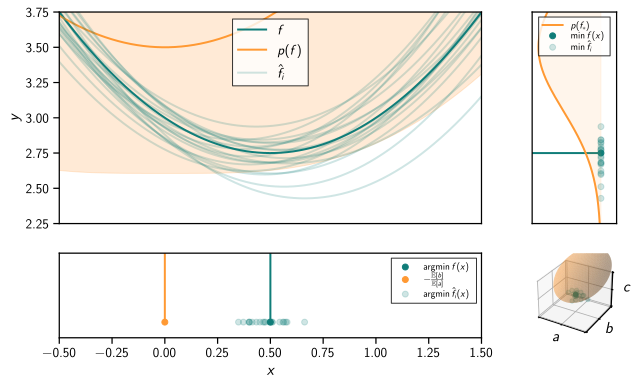

In [6]:
"""Plot objective, noisy function evaluations and prior knowledge."""

# Evaluate some quantities to plot
yy = np.linspace(ylim00[0], ylim00[1], 1000)
fun_opt0_mean = fun_opt0(fun_params0, xx).mean
fun_opt0_std = np.sqrt(fun_opt0(fun_params0, xx).var)
fun0_pdf = fun_opt0(fun_params0, x0).pdf(yy)
fun0_pdf_max = np.max(fun0_pdf)

# Plot setup
fig = plt.figure(figsize=[10, 6])
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 1], height_ratios=[2.5, 1])

ax00 = fig.add_subplot(gs[0, 0])
ax10 = fig.add_subplot(gs[1, 0], sharex=ax00)
ax01 = fig.add_subplot(gs[0, 1], sharey=ax00)
ax11 = fig.add_subplot(gs[1, 1], projection="3d")

# Function
ax00.plot(xx, f(xx), label="$f$", color="C0")
ax00.plot(xx, fun_opt0_mean, color="C1", label="$p(f)$")
ax00.fill_between(
    x=xx,
    y1=fun_opt0_mean - 2 * fun_opt0_std,
    y2=fun_opt0_mean + 2 * fun_opt0_std,
    color="C1",
    alpha=0.2,
)

# Parameters
def gaussian_credible_region_3d(mean, cov, alpha=0.95):
    """Compute the x,y,z coordinates of a 3D Gaussian credible region."""
    from scipy.stats import chi2
    
    # Determine sphere radius (https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Interval)
    dim = 3
    radius = np.sqrt(chi2.ppf(alpha, df=dim))
    
    # Cholesky decomposition
    L = np.linalg.cholesky(cov)
    
    # Spheroid using polar coordinates
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones_like(u), np.cos(v))

    # Affine transformation
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot(L, [x[i,j],y[i,j],z[i,j]]) + mean

    return x, y, z

x, y, z = gaussian_credible_region_3d(mean=fun_params0.mean, cov=fun_params0.cov)
ax11.plot_surface(x, y, z, color='C1', alpha=0.3, linewidth=1)
ax11.scatter(a, b, c, color='C0')

# Function range
ax01.scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
ax01.hlines(y=f(x_opt), xmin=ylim10[0], xmax=ylim10[1] + ylim10[0], zorder=-1, color="C0")
ax01.plot(ylim10[1] + ylim10[0] - fun0_pdf / fun0_pdf_max, yy, color="C1", label="$p(f_*)$")
ax01.fill_betweenx(
    y=yy,
    x1=ylim10[1] + ylim10[0] - fun0_pdf / fun0_pdf_max,
    x2=ylim10[1] + ylim10[0],
    color="C1",
    alpha=0.1,
)

# Domain
ax10.scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
ax10.vlines(x_opt, ymin=0, ymax=ylim10[1], zorder=-1, color="C0")
ax10.scatter(x0, 0, color="C1", label="$- \\frac{\\mathbb{E}[b]}{\\mathbb{E}[a]}$")
ax10.vlines(x0, ymin=0, ymax=ylim10[1], zorder=-1, color="C1")

# Samples
for i in range(n_samples):
    noise = eps.sample(rng=rng)
    x_opt_noise = -(b + noise[1]) / (a + noise[0])
    if i == 0:
        sample_label = "$\\hat{f}_i$"
        sample_min_label = "$\min \\hat{f}_i$"
        sample_argmin_label = "$\operatorname{argmin} \hat{f}_i(x)$"
    else:
        sample_label = None
        sample_argmin_label = None
        sample_min_label = None
    ax00.plot(xx, f_hat(xx, rng, noise), color="C0", alpha=0.2, label=sample_label)
    ax10.scatter(x_opt_noise, 0, color="C0", alpha=0.2, label=sample_argmin_label)
    ax01.scatter(
        ylim10[1] + ylim10[0],
        f_hat(x_opt_noise, rng, noise),
        color="C0",
        alpha=0.2,
        label=sample_min_label,
    )
    ax11.scatter(a + noise[0], b + noise[1], c + noise[2], color='C0', alpha=0.2)

# Adjust axis visibility, labels and legends
ax00.get_xaxis().set_visible(False)
ax10.get_yaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax01.get_xaxis().set_visible(False)
ax11.get_xaxis().set_ticklabels([])
ax11.get_yaxis().set_ticklabels([])
ax11.get_zaxis().set_ticklabels([])

ax00.set_ylim(ylim00)
ax00.set_xlim([x_opt - 1, x_opt + 1])
ax10.set_ylim(ylim10)
ax01.set_xlim(ylim10)
ax11.set_xlim([a - 1, a + 1])
ax11.set_ylim([b - 1, b + 1])
ax11.set_zlim([c - 1, c + 1])
ax00.set_ylabel("$y$")
ax10.set_xlabel("$x$")
ax11.set_xlabel("$a$", labelpad=-12)
ax11.set_ylabel("$b$", labelpad=-12)
ax11.set_zlabel("$c$", labelpad=-12)
ax00.legend(loc="upper center")
ax01.legend(loc="upper center", fontsize=10, labelspacing=0)
ax10.legend(loc="upper right", fontsize=10, labelspacing=0)

plt.show()

We would like to use this prior information to solve the optimization problem in question. In order to do so we need to collect information about the problem, which we do by evaluating $\hat{f}$ at chosen points $x_i$. 

### Policy

In order to collect information about the problem we need to decide where to evaluate the (noisy) objective function $\hat{f}$. This is done via a _policy_ $\pi$. In principle this can be any function which maps to the domain of $\hat{f}$, however it is sensible to use the model of the problem our algorithm is iteratively constructing. This is called a model-based policy.

Here, we will collect observations by selecting actions randomly around where we currently belief the minimum to be. This is motivated by an exploration-exploitation trade-off. While we are unsure where the minimum is we should evaluate $\hat{f}$ with different actions to explore and find smaller function values. If we are certain about the parameter values $(a,b,c)$, we should keep evaluating close to the minimum to find its exact location.

In [7]:
import functools

# Stochastic model-based policy
def explore_exploit_policy_with_random_seed(fun_params0, rng=None):
    """Policy exploring around the estimate of the minimum based on the certainty about the parameters."""
    if rng is None:
        rng = np.random.default_rng()
    a0, b0, c0 = fun_params0
    return -b0.mean / a0.mean + randvars.Normal(0, np.trace(fun_params0.cov)).sample(rng=rng)

explore_exploit_policy = functools.partial(explore_exploit_policy_with_random_seed, rng=rng)

### Action and Observation

We now use our policy to collect observations about the problem by evaluating the objective function at the suggested evaluation point(s).

In [8]:
def observe(fun, x):
    """Evaluate the objective at a given location."""
    return fun(x)

### Inference Step

Given the noise model, we can compute the posterior distribution over the parameters $(a, b, c)$ for a given action $x$ using Bayes' theorem. To that end, let
$$\Phi = \begin{pmatrix}\frac{1}{2}x^2 \\ x\\1\end{pmatrix} \in \mathbb{R}^{3}$$

be the feature vector for a single action. We can rewrite the evaluation of the objective function $f(x)$ as a linear function in the parameters $(a,b,c)$ like so
$$
f(x) = \frac{1}{2}ax^2 + bx + c = \Phi^\top \begin{pmatrix}a \\ b \\ c \end{pmatrix}
$$

#### Prior
We assume a Gaussian prior distribution
$$
(a, b, c) \sim \mathcal{N}(\mu, \Sigma),
$$

which expresses our belief over the parameters of the latent 2nd degree polynomial.

#### Likelihood
We assumed a Gaussian noise model of the form $\varepsilon = (\varepsilon_a, \varepsilon_b, \varepsilon_c) \sim \mathcal{N}(0, \Lambda)$. Therefore the noise corrupted objective evaluated at an action $x$ is distributed as
$$
\hat{y} = \hat{f}(x) = \Phi^\top \begin{pmatrix}a + \varepsilon_a\\ b + \varepsilon_b\\ c + \varepsilon_c\end{pmatrix} = f(x) + \Phi^\top \varepsilon
$$

This implies the following Gaussian likelihood defining the observation model.
$$
p(y \mid a, b, c, x) = \mathcal{N}\big(y; f(x), \Phi^\top \Lambda \Phi\big)
$$

#### Posterior
Using the rules of Gaussian inference, we arrive at the posterior distribution
$$
p(a, b, c \mid x, y) = \mathcal{N}((a,b,c); m, S),
$$

where
$$
\begin{aligned}
m &= \mu + \Sigma \Phi \big(\Phi^\top (\Sigma + \Lambda) \Phi \big)^{-1}(y - \Phi^\top \mu)\\
S &= \Sigma - \Sigma \Phi \big(\Phi^\top (\Sigma + \Lambda) \Phi \big)^{-1} \Phi^\top \Sigma.
\end{aligned}
$$

In the posterior mean for the parameters of $f$ the prior mean $\mu$ is updated with the difference between the observed function value and the expected function value based on the prior $y - \Phi^\top \mu$. This update to the current mean of the belief is scaled with how uncertain we are about the parameters and what level of noise we expect $\big(\Phi^\top (\Sigma + \Lambda) \Phi \big)^{-1}$. If the combined uncertainty is small the update term of the mean gets weighted more highly than if the combined uncertainty is large. Similarly for the covariance our prior uncertainty about the parameters $\Sigma$ is reduced a certain amount in each iteration depending on how certain we are about the parameters and the degree of noise. This Bayesian update therefore combines *what is known* and *what is observed* about the problem.

In [9]:
def belief_update(fun_params, x, y, Lambda=Lambda):
    """Update the belief over the parameters with an observation."""
    # Feature vector
    x = np.asarray(x).reshape(1, -1)
    Phi = np.vstack((0.5 * x ** 2, x, np.ones_like(x)))

    # Mean and covariance
    mu = fun_params.mean
    Sigma = fun_params.cov

    # Gram matrix
    gram = Phi.T @ (Sigma + Lambda) @ Phi

    # Posterior Mean
    m = mu + Sigma @ Phi @ np.linalg.solve(gram, y - Phi.T @ mu)

    # Posterior Covariance
    S = Sigma - Sigma @ Phi @ np.linalg.solve(gram, Phi.T @ Sigma)

    return randvars.Normal(m, S)

Note, for simplicity we assumed the noise level of the data is known. Usually in practice this is not the case. However, one can actually infer the noise level from the data using the probabilistic framework. For more details, see the [advantages of PN methods](https://probabilistic-numerics.github.io/website/).

### Stopping Criteria

Finally, we need to decide when to stop. From a probabilistic perspective we should terminate when our uncertainty about the quantity of interest, in this case the minimum, is sufficiently small either in absolute or relative terms. Here, we use the belief over the parameters as a proxy instead since the uncertainty over the minimum is computationally intractable. Our combined uncertainty over the parameters is given as the trace $\operatorname{tr}(S)$ of the covariance matrix. Additionally, we also make sure a certain computational budget is not exceeded.

In [10]:
def stopping_criterion(fun_params0, current_iter, maxiter=10 ** 4, tol=10 ** -3):
    """Convergence criteria."""
    # Uncertainty over parameters given by the trace of the covariance.
    trace_cov = np.trace(fun_params0.cov)
    if trace_cov < tol:
        return True, "uncertainty_abstol"
    elif trace_cov < np.linalg.norm(fun_params0.mean, ord=2) ** 2 * tol:
        return True, "uncertainty_reltol"
    # Fixed maximum budget
    elif current_iter >= maxiter:
        return True, "maxiter"
    else:
        return False, None

## The Algorithm

Putting all the components together we arrive at the following algorithm.

In [11]:
def probsolve_qp(
    fun,
    fun_params0,
    policy=explore_exploit_policy,
    stopping_criterion=stopping_criterion,
    belief_update=belief_update,
    callback=None,
):
    """
    Probabilistic 1D Quadratic Optimization.

    PN method solving unconstrained one-dimensional (noisy) quadratic
    optimization problems only needing access to function evaluations.

    Parameters
    ----------
    fun : callable
        Objective function to optimize.
    fun_params0 : randvars.RandomVariable
        Prior on the parameters of the objective function.
    policy : callable
        Policy returning actions.
    stopping_criterion : callable
        Stopping criterion determining convergence.
    belief_update : callable
        Inference routine updating the belief over the parameters.
    callback : callable
        Callback function used to return intermediate quantities of the iteration. Used for plotting.

    Returns
    -------
    x_opt : float
        Estimated minimum of ``f``.
    fun_opt : randvars.RandomVariable
        Belief over the optimal value of the objective function.
    fun_params : randvars.RandomVariable
        Belief over the parameters of the objective function.
    info : dict
        Additional information about the solve, e.g. convergence.
    """
    # Initialization
    iteration = 0
    
    # Sampling is only for plotting purposes (see below),
    # thus this rng is not exposed.
    rng2 = np.random.default_rng(seed=42)
    
    # Iterate until convergence
    while True:

        # Stopping criterion
        has_converged, conv_crit = stopping_criterion(fun_params0, iteration)
        if has_converged:
            break

        # Policy
        x = policy(fun_params0)
        
        # Observation
        noise = eps.sample(rng=rng2)  # for plotting purposes only, this is not available in practice
        y = observe(lambda x: fun(x, noise), x)

        # Belief update
        fun_params0 = belief_update(fun_params0, x, y)

        # Callback function
        if callback is not None:
            callback(x, y, fun_params0, noise)

        iteration += 1

    # Belief over optimal function value and optimum
    x_opt0 = -fun_params0.mean[1] / fun_params0.mean[0]
    fun_opt0 = np.array([0.5 * x_opt0 ** 2, x_opt0, 1]).T @ fun_params0        

    # Information on convergence
    info = {"iter": iteration, "conv_crit": conv_crit}

    return x_opt0, fun_opt0, fun_params0, info

We now solve the problem using our newly implemented probabilistic numerical method. We also use a `callback` function to extract quantities at each iteration for analysis and plotting purposes.

In [12]:
# Callback function to return iterates
x_iterates = [None]
y_iterates = [None]
fun_params0_iterates = [fun_params0]
noise_samples = [None]


def callback(x, y, fun_params, noise):
    x_iterates.append(x)
    y_iterates.append(y)
    fun_params0_iterates.append(fun_params)
    noise_samples.append(noise)


# Solve noisy quadratic optimization problem
def fun(x, noise):
    return f_hat(x, rng=rng, noise=noise)
x_opt_post, fun_opt_post, fun_params_post, info = probsolve_qp(fun, fun_params0, callback=callback)

# Print results
print(f"Estimated optimum: {x_opt_post:.4f} vs. true optimum: {x_opt:.4f}")
print(
    f"Estimated optimal value: {fun_opt_post.mean:.4f} "
    + "\u00B1"
    + f" {2 * fun_opt_post.std:.4f} vs. true optimal value: {f(x_opt):.4f}"
)
print(info)

Estimated optimum: 0.5011 vs. true optimum: 0.5000
Estimated optimal value: 2.7459 ± 0.0048 vs. true optimal value: 2.7500
{'iter': 5148, 'conv_crit': 'uncertainty_reltol'}


The PN method iteratively updates the prior belief over the coefficients of the quadratic function based on observations of function values at inputs given by its internal policy. This results in a posterior belief over the parameters (bottom right) and the optimal function value (top right). We also obtain an estimate for the minimum given as $x_* = - \frac{\mathbb{E}[b]}{\mathbb{E}[a]}$ from the posterior distribution over the parameters.

In [13]:
"""Animation of 1D stochastic quadratic optimization using a PN method."""

# Animation parameters
total_frames = np.minimum(20, len(x_iterates))

# Set up figure and axes
fig = plt.figure(figsize=[10, 6])
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 1], height_ratios=[2.5, 1])

ax00 = fig.add_subplot(gs[0, 0])
ax10 = fig.add_subplot(gs[1, 0], sharex=ax00)
ax01 = fig.add_subplot(gs[0, 1], sharey=ax00)
ax11 = fig.add_subplot(gs[1, 1], projection="3d")

fig.patch.set_alpha(0.) # set figure background opacity to 0
plt.close()

# Plot setup
yy = np.linspace(ylim00[0], ylim00[1], 1000)

def animate(i):
    # Clear axes
    ax00.cla()
    ax10.cla()
    ax01.cla()
    ax11.cla()

    # Select data
    _max_first_iters = 10
    if len(x_iterates) > _max_first_iters:
        alg_iter_list = np.concatenate(
            [np.arange(0, _max_first_iters), 
             np.round(np.exp(np.linspace(np.log(_max_first_iters), np.log(len(x_iterates) - 1), 
                                  total_frames - _max_first_iters))).astype(int)])
    else:
        alg_iter_list = np.arange(0, len(x_iterates))

    alg_iter = alg_iter_list[i]
    x = x_iterates[alg_iter]
    y = y_iterates[alg_iter]
    fun_params0 = fun_params0_iterates[alg_iter]
    noise = noise_samples[alg_iter]

    # Plot objective and noisy evaluations
    fun_opt0_mean = fun_opt0(fun_params0, xx).mean
    fun_opt0_std = np.sqrt(fun_opt0(fun_params0, xx).var)
    x_opt0 = -fun_params0.mean[1] / fun_params0.mean[0]
    fun0_pdf = fun_opt0(fun_params0, x_opt0).pdf(yy)
    fun0_pdf_max = np.max(fun0_pdf)

    # Function
    ax00.plot(xx, f(xx), label="$f$", color="C0")
    if i > 0:
        ax00.plot(xx, f_hat(xx, rng=rng, noise=noise), label=f"$\hat{{f}}_{{{alg_iter}}}$", alpha=0.2, color="C0")
    ax00.plot(xx, fun_opt0_mean, color="C1", label="$p(f)$")
    ax00.fill_between(
        x=xx,
        y1=fun_opt0_mean - 2 * fun_opt0_std,
        y2=fun_opt0_mean + 2 * fun_opt0_std,
        color="C1",
        alpha=0.2,
    )
    
    # Parameters
    x_credregion, y_credregion, z_credregion = gaussian_credible_region_3d(mean=fun_params0.mean, 
                                                                           cov=fun_params0.cov)
    ax11.plot_surface(x_credregion, y_credregion, z_credregion, color='C1', alpha=0.3, linewidth=1)
    ax11.scatter(a, b, c, color='C0')
    if i > 0:
        ax11.scatter(a + noise[0], b + noise[1], c + noise[2], color="C0", alpha=0.2)
    
    # Function range
    ax01.scatter(ylim10[1] + ylim10[0], f(x_opt), label="$\min f(x)$")
    ax01.hlines(y=f(x_opt), xmin=ylim10[0], xmax=ylim10[1] + ylim10[0], zorder=-1, color="C0")
    ax01.plot(ylim10[1] + ylim10[0] - fun0_pdf / fun0_pdf_max, yy, color="C1", label="$p(f_*)$")
    ax01.fill_betweenx(
        y=yy,
        x1=ylim10[1] + ylim10[0] - fun0_pdf / fun0_pdf_max,
        x2=ylim10[1] + ylim10[0],
        color="C1",
        alpha=0.1,
    )
    ax01.scatter(ylim10[1] + ylim10[0], y, color="C3", marker="x", label=f"obs. $\hat{{y}}_{{{alg_iter}}}$")
    
    # Initial hline has y=None, which does not work
    if y is not None:
        ax01.hlines(y=y, xmin=ylim10[0], xmax=ylim10[1] + ylim10[0], zorder=-1, color="C0", alpha=0.2)

    # Domain
    ax10.scatter(x_opt, 0, label="$\operatorname{argmin} f(x)$")
    ax10.vlines(x_opt, ymin=0, ymax=ylim10[1], zorder=-1, color="C0")
    ax10.scatter(x_opt0, 0, color="C1", label="$- \\frac{\\mathbb{E}[b]}{\\mathbb{E}[a]}$")
    ax10.vlines(x_opt0, ymin=0, ymax=ylim10[1], zorder=-1, color="C1")
    ax10.scatter(x, 0, color="C3", marker="x", label=f"action $x_{{{alg_iter}}}$")
    
    # Initial vline has x=None, which does not work
    if x is not None:
        ax10.vlines(x, ymin=0, ymax=ylim10[1], zorder=-1, color="C0", alpha=0.2)

    # Adjust axis visibility, labels and legends
    ax00.get_xaxis().set_visible(False)
    ax10.get_yaxis().set_visible(False)
    ax01.get_yaxis().set_visible(False)
    ax01.get_xaxis().set_visible(False)
    ax11.get_xaxis().set_ticklabels([])
    ax11.get_yaxis().set_ticklabels([])
    ax11.get_zaxis().set_ticklabels([])

    ax00.set_ylim(ylim00)
    ax00.set_xlim([x_opt - 1, x_opt + 1])
    ax10.set_ylim(ylim10)
    ax01.set_xlim(ylim10)
    ax11.set_xlim([a - 1, a + 1])
    ax11.set_ylim([b - 1, b + 1])
    ax11.set_zlim([c - 1, c + 1])
    ax00.set_ylabel("$y$")
    ax10.set_xlabel("$x$")
    ax11.set_xlabel("$a$", labelpad=-12)
    ax11.set_ylabel("$b$", labelpad=-12)
    ax11.set_zlabel("$c$", labelpad=-12)
    ax00.legend(loc="upper center")
    ax01.legend(loc="upper center", fontsize=10, labelspacing=0)
    ax10.legend(loc="upper right", fontsize=10, labelspacing=0)

In [14]:
from matplotlib import animation
from IPython.display import HTML

# Animation setup
anim = animation.FuncAnimation(
    fig, func=animate, frames=total_frames, interval=1250, repeat_delay=4000, blit=False
)
HTML(anim.to_jshtml())

By stepping through the animation we can see how the uncertainty over the parameters in the bottom right contracts. Depending on which action is taken it contracts differently for the different parameters of the latent quadratic function. Early on the exploration factor of our policy dominates and quite different actions are taken. This quickly reduces the uncertainty about the constant offset $c$. Later during the run of the algorithm as uncertainty about $a$ and $b$ decreases, more observations close to the true minimal function value reinforce the belief over the location of the minimum. We also observe that at convergence there is still uncertainty about the function left. Here a trade-off between learning the parameters and the minimal function value given a certain computational budget needs to be made. Which is more important may depend on the application and also influence the choice of stopping criterion. For example, if we are only interested in learning the optimal function value $f(x_*)$ but not necessarily the location of the minimum $x_*$, we could terminate as soon as $\operatorname{Var}(f_*)$ is sufficiently small. This would take less observations in this case.

**Why not simply solve the problem multiple times and average?**

Playing devil's advocate one might suggest that little was gained using a probabilistic numerical method versus simply querying the noisy problem $3 k$ times to obtain $k$ noisy estimates for the minimum. We can then obtain an empirical estimate for the mean and variance of the minimum. However, this naive approach quickly becomes computationally infeasible for the $n$-dimensional case. To obtain just a single sample estimate for the minimum, we would have to obtain a noisy sample of the parameters. This requires us to evaluate $f$ quadratically often in the dimensionality $n$ of the parameters.

While the PN method also relies on observations about the problem these are guided by a policy which selects informative samples based on the current model. Further, the estimate of the minimum is a compromise between the observations and our prior knowledge about the problem. This regularizes the result which is particularly important for a small computational budget relative to the noise level.

## Advantages of PN Methods

Probabilistic numerical methods have a number of advantages over classical methods, some of which we outline here. For a more exhaustive list, see the [values of the probabilistic approach](https://probabilistic-numerics.github.io/website/).

As we have just seen, the probabilistic inference framework naturally handles stochastic observations of the problem to be solved. Also one can encode more prior knowledge beyond just a guess for the solution of the numerical problem by specifying the degree of certainty in this initial guess.

### New Interpretation of Classic Methods

In the noise-free case, where $\Lambda \rightarrow 0$, we converge in three iterations. This means our probabilistic numerical method recovers the strategy we proposed for the exact case at the very beginning, where we evaluate the function $f$ three times to obtain the parameters $a, b$ and $c$ and then simply return $x_* = -\frac{b}{a}$. Thus the PN approach offers a new interpretation for this straightforward classic approach as an inference procedure where observations are taken to be exact.

In [15]:
# Solve exact quadratic optimization problem
x_exact, fun_opt_exact, fun_params_exact, info_exact = probsolve_qp(
    lambda x, noise: f(x), # exact objective
    fun_params0, # same prior
    belief_update=lambda p, x, y: belief_update(p, x, y, Lambda=10**-16 * np.eye(3)) # assume no noise
)

In [16]:
print(f"Estimated optimum: {x_exact:.4f} vs. true optimum: {x_opt:.4f}")
print(
    f"Estimated optimal value: {fun_opt_exact.mean:.4f} "
    + "\u00B1"
    + f" {2 * fun_opt_exact.std:.4f} vs. true optimal value: {f(x_opt):.4f}"
)
print(info_exact)

Estimated optimum: 0.5000 vs. true optimum: 0.5000
Estimated optimal value: 2.7500 ± 0.0000 vs. true optimal value: 2.7500
{'iter': 3, 'conv_crit': 'uncertainty_abstol'}


### Hyperparameter Optimization

In this simple example, we conveniently assumed the noise level $\Lambda$ to be known, which in practice it is often not. However using the probabilistic framework we can learn the noise level from the data by maximizing the model evidence. This is an example of a more general advantage of PN methods. They often provide a principled, automatic way to set degrees of freedom, i.e. parameters of a numerical method, based on observations of the problem.

### Mutually Related Problems

When solving multiple mutually related problems of the same type, the PN approach can provide a way to transfer information between them. In our case, suppose we are to solve a new quadratic optimization problem with objective $\hat{g}(x) \approx \hat{f}(x)$. We could then use the posterior of a previous solution as a prior for the new problem. Depending on the degree of similarity between $\hat{g}$ and $\hat{f}$, this can speed up the solution considerably. In machine learning lingo, this can be seen as a form of *transfer learning*.

In [17]:
# Quadratic objective with slightly different parameters
a_g = a + 0.2
b_g = b - 0.02
c_g = 1.01 * c

def g_hat(x, noise=None):
    if noise is None:
        noise = eps.sample()
    return 0.5 * (a_g + noise[0]) * x ** 2 + (b_g + noise[1]) * x + c_g + noise[2]

# Construct new prior from previous problem (with increased prior uncertainty)
fun_params0_g = randvars.Normal(mean=fun_params_post.mean, cov=10 * fun_params_post.cov)

# Solve with posterior from previous problem as prior
x_opt_g_post, fun_opt_g_post, fun_params_g_post, info_g = probsolve_qp(g_hat, fun_params0_g)

In [18]:
# Print results
x_opt_g = - b_g / a_g
print(f"Estimated optimum: {x_opt_g_post:.4f} vs. true optimum: {x_opt_g:.4f}")
print(
    f"Estimated optimal value: {fun_opt_g_post.mean:.4f} "
    + "\u00B1"
    + f" {2 * fun_opt_g_post.std:.4f} vs. true optimal value: {g_hat(x_opt_g, noise=np.zeros(3)):.4f}"
)
print(info_g)

Estimated optimum: 0.4738 vs. true optimum: 0.4636
Estimated optimal value: 2.7880 ± 0.0045 vs. true optimal value: 2.7935
{'iter': 5444, 'conv_crit': 'uncertainty_reltol'}


We only take a fraction of the iterations on this problem compared to the first.

In [19]:
info_g["iter"] / info["iter"]

1.0574980574980575

We can also transfer information between noisy problems in a different way. If we know that the additive noise between two different problems arises via the same process, it is then sensible to choose the initial noise level $\Lambda$ as the learned value from the previous problem.

## Connections to other Concepts

For those familiar with probabilistic inference, many of the presented concepts might be familiar. In fact there are very close connections between this example and various concepts from statistics and machine learning. 

### GP Regression

The inference procedure described here is an example of Gaussian process regression with a polynomial kernel. The prior over the parameters corresponds to the weight-space view, whereas the induced prior over the function $f$ corresponds to the function space view.

### Bayesian Optimization

Bayesian Optimization is a global optimization technique often applied to black-box functions which are expensive to evaluate. Such methods are probabilistic numerical methods and the example presented here can be viewed as a special case of Bayesian Optimization with a Gaussian process surrogate. Some philosophical differences are that the objective is comparatively cheap to evaluate in the quadratic case and that for a low level routine, such as quadratic 1D optimization, only computationally inexpensive policies are possible.

### Probabilistic Linear Solvers

Solving a convex quadratic optimization problem of the form 
$$
\min_{x \in \mathbb{R}^n}\frac{1}{2}x^\top A x + b^\top x + c
$$

for a symmetric positive definite matrix $A$ is equivalent to solving the linear system $Ax=-b$. Analogously, there are parallels between this example and a 1D version of a [probabilistic linear solver](../api/automod/probnum.linalg.problinsolve.rst#probnum.linalg.problinsolve), if one assumes that the (noisy) gradient can be evaluated as well.

---

**Implementation in ProbNum**

Interested in how this method would be implemented as part of ProbNum's codebase? Check out the development guide outlining how to [add a PN method to ProbNum](../development/implementing_a_probnum_method.ipynb).

---
